In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)

10.1
[07/19 19:15:41]
1.4.0


In [2]:
print('torch.cuda.is_available():',torch.cuda.is_available())
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
----- torch.cuda.empty_cache() -----
torch.cuda.memory_reserved(): 0.00 Mb
torch.cuda.memory_allocated(): 0.00 Mb
torch.cuda.memory_cached(): 0.00 Mb


# Paths: modify here

In [3]:
device = torch.device("cuda:0")

cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
#cam_path = r'D:\CalibrationData\CameraCalibration\2019_12_13_Lada_Capture_k1k2k3p1p2\FinalCamParams\cam_params.json'
cam_path = './22_data/cam_params.json'

#mesh_dir = r'./21_data/input/200616_SilhoutteFitted/f_v_vn_vt'
mesh_dir = './22_data/200619_SilFittedMesh_vtAdded'

#img_dir = './14g_data/input/images'
img_dir = r'Z:\2019_12_13_Lada_Capture\200512_MeshSparseFitted\images'

# img_names = ['03052', '03990', '04917', '06950']
# img_names = ['03052', '03067', '04917', '06250', '06550']
img_names = ['03052', '03067', '04735', '06550', '06250']
# img_names = ['03052', '04735']

clean_plate_dir = './22_data/CleanPlates/undistorted'

contour_dir = './22_data/200619_contours_5x5_dil_ero'
texturemap_path = None

texturemap_shape = (1024, 1024, 1)
image_size = 1080

# input image size
actual_img_shape = (2160, 4000)

print('Meshes:')
mesh_paths = []
for img_name in img_names:
    mesh_path = mesh_dir + '/{}.obj'.format(img_name)
    mesh_paths.append(mesh_path)
# mesh_paths = [mesh_dir + '/InterpolatedWithSparse.obj']
print(mesh_paths)
n_forwards = len(img_names)*len(cams)
print('{} renderes'.format(n_forwards))

out_dir = './26_data'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
out_dir += '/output'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
print(out_dir)

Meshes:
['./22_data/200619_SilFittedMesh_vtAdded/03052.obj', './22_data/200619_SilFittedMesh_vtAdded/03067.obj', './22_data/200619_SilFittedMesh_vtAdded/04735.obj', './22_data/200619_SilFittedMesh_vtAdded/06550.obj', './22_data/200619_SilFittedMesh_vtAdded/06250.obj']
80 renderes
./26_data/output


# load contours (png)

In [4]:
contours = {}
for img_name in img_names:
    if img_name not in contours:
        contours[img_name] = []
    for cam_idx in range(16):
        cnt_path = os.path.join(contour_dir, '{}_{}.png'.format(img_name, cam_idx))
        cnt = imageio.imread(cnt_path).astype(np.float32) / 255.0
        contours[img_name].append(cnt)
for k, v in contours.items():
    print(k, len(v))

03052 16
03067 16
04735 16
06550 16
06250 16


# load cameras

In [5]:
def load_cameras(cam_path, device, actual_img_shape):
    print('actual_img_shape:',actual_img_shape)
    h = actual_img_shape[0]
    w = actual_img_shape[1]
    img_size = min(w, h)
    
    # load cameras
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

    with open(cam_path, 'r') as f:
        j = json.load(f)
        camera_params = j['cam_params']

    cam_params = []
    Rs, Ts, focal_lengths, principal_points = [], [], [], []
    for cam_idx, cam in enumerate(cams):
        cam_param = camera_params[str(cam_idx)]
        # for undistortion
        fx = cam_param['fx']
        fy = cam_param['fy']
        cx = cam_param['cx']
        cy = cam_param['cy']
        k1 = cam_param['k1']
        k2 = cam_param['k2']
        k3 = cam_param['k3']
        p1 = cam_param['p1']
        p2 = cam_param['p2']
        
        rvec = np.float32(cam_param['rvec'])
        T = np.float32(cam_param['tvec'])
        R, _ = cv2.Rodrigues(rvec)
        Rs.append(R.T)
        Ts.append(T)
        
        cx_corrected = cx*2/img_size - w/img_size
        cy_corrected = cy*2/img_size - h/img_size
        fx_corrected = fx*2/img_size
        fy_corrected = fy*2/img_size
        principal_point = np.array([cx_corrected, cy_corrected]).astype(np.float32)
        focal_length = np.array([fx_corrected, fy_corrected]).astype(np.float32)
        focal_lengths.append(focal_length)
        principal_points.append(principal_point)

        K = np.float32([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        dist = np.float32([k1, k2, p1, p2, k3])
        cam_params.append({'K': K, 'dist': dist, 'R': R, 'T': T, 'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy})
    
    R_torch = torch.from_numpy(np.array(Rs).astype(np.float32))
    T_torch = torch.from_numpy(np.array(Ts).astype(np.float32))
    focal_length = torch.from_numpy(np.array(focal_lengths).astype(np.float32))
    principal_point = torch.from_numpy(np.array(principal_points).astype(np.float32))
    out_for_torch = {'R': R_torch, 'T': T_torch, 'fl': focal_length, 'pp': principal_point}
    return cam_params, out_for_torch

cam_params, cams_torch = load_cameras(cam_path, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


# load target, bg images

In [45]:
def load_images(img_dir, img_names):
    image_refs_out = {}
    crops_out = {}
    
    w = 2160 / 2
    for img_name in img_names:
        path = img_dir + '/{}'.format(img_name)
        img_paths = sorted(glob.glob(path + '/*.png'))
        image_refs_undistort = []
        for i, path in enumerate(img_paths):
            if 'pgm' in path:
                continue
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
            image_refs_undistort.append(img)

        image_refs_cropped = []
        for i in range(len(image_refs_undistort)):
            image = image_refs_undistort[i]
            cx = image.shape[1] / 2

            image = image_refs_undistort[i]
            img = image[:, int(cx-w):int(cx+w)]
            img = cv2.resize(img, (image_size, image_size))
            img = cv2.flip(img, -1)
            image_refs_cropped.append(img)
        image_refs_out[img_name] = image_refs_undistort
        crops_out[img_name] = image_refs_cropped
    return image_refs_out, crops_out

img_refs_undistorted, img_refs = load_images(img_dir, img_names)
print('img_refs_undistorted:', img_refs_undistorted.keys())
for k, v in img_refs_undistorted.items():
    print('  {}: {} images'.format(k, len(v)))
print('  {}'.format(img_refs_undistorted[list(img_refs_undistorted.keys())[0]][0].shape))
print('img_refs:', img_refs.keys())
print('  {}'.format(img_refs[list(img_refs.keys())[0]][0].shape))

img_refs_undistorted: dict_keys(['03052', '03067', '04735', '06550', '06250'])
  03052: 16 images
  03067: 16 images
  04735: 16 images
  06550: 16 images
  06250: 16 images
  (2160, 4000)
img_refs: dict_keys(['03052', '03067', '04735', '06550', '06250'])
  (1080, 1080)


# load clean plates

In [46]:
def load_clean_plates(img_dir, cam_params):
    img_paths = sorted(glob.glob(img_dir + '/*.PNG'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        images0.append(img)
        images_undistort.append(img)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.float32)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.flip(img, -1)
        # img = np.dstack([img, img, img])
        clean_plates_cropped.append(img)
    
    return images0, images_undistort, clean_plates_cropped 

clean_plates_original, clean_plates_undistort, clean_plates = load_clean_plates(clean_plate_dir, cam_params)
print('clean_plates_original:', clean_plates_original[0].shape)

clean_plates_original: (2160, 4000)


# Check contour masks

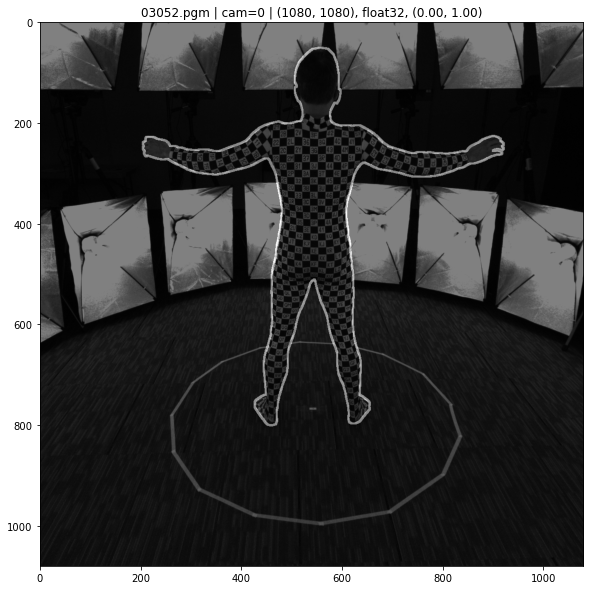

In [48]:
for img_name, img_ref in img_refs.items():
    for cam_idx in range(len(img_ref)):
        target_img = img_ref[cam_idx]
        cnt = contours[img_name][cam_idx]
        
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.flip(target_img, -1), cmap='gray')
        plt.imshow(cnt, alpha=0.5, cmap='gray')
        plt.title('{}.pgm | cam={} | {}, {}, ({:.2f}, {:.2f})'.format(img_name, cam_idx, cnt.shape, cnt.dtype, np.min(cnt), np.max(cnt)))
        plt.show()
        break
    break

# Model

In [56]:
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        super().__init__()

        self.cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
        self.device = device
        self.image_size = kwargs.get('image_size', None)
        self.n_cams = len(self.cams)
                
        image_refs = kwargs.get('image_refs', None)
        self.image_refs = {}
            
        for img_name, img_list in image_refs.items():
            # (16, 1080, 1080, 1)
            imgs_torch = torch.from_numpy(np.array(img_list).astype(np.float32)).to(self.device)
            self.image_refs[img_name] = imgs_torch
            
        # set clean_plates:
        clean_plates = kwargs.get('clean_plates', None)
        if clean_plates is not None:
            # (16, 1080, 1080, 1)
            self.clean_plates = torch.from_numpy(np.array(clean_plates).astype(np.float32)).unsqueeze(-1).to(self.device)
        
        # load texturemaps: [0.0, 1.0] float
        texturemap_path = kwargs.get('texturemap_path', None)
        texturemap_shape = kwargs.get('texturemap_shape', None)
        if texturemap_path is not None:
            texturemap = cv2.imread(texturemap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
            texture_map_torch = torch.from_numpy(texturemap).unsqueeze(0).unsqueeze(-1)
        else:
            texture_map_torch = torch.from_numpy(np.zeros((1, texturemap_shape[0], texturemap_shape[1], 1)).astype(np.float32))
        self.texture_map = nn.Parameter(texture_map_torch.to(self.device), requires_grad=True)
        
        
        # batch_size
        self.batch_dict = {'img_name': [], 'cam_idx': [], 'mesh_idx': []}
        i = 0
        for img_name in self.image_refs.keys():
            for cam_idx in range(self.n_cams):
                self.batch_dict['img_name'].append(img_name)
                self.batch_dict['cam_idx'].append(cam_idx)
                self.batch_dict['mesh_idx'].append(i)
            i += 1
            
        # ====================
        # lights & renderers
        # ====================
        self.renderer = self._init_renderer()

        # camera batches
        self.cam_params = kwargs.get('cam_params', None)
        self.batch_size = kwargs.get('batch_size', None)
        self.n_batch = kwargs.get('n_batch', None)
        self.cam_batches = self._init_camera_batches(self.cam_params, batch_dict=self.batch_dict, n_batch=self.n_batch, batch_size=self.batch_size)
        
        # set mesh
        mesh_paths = kwargs.get('mesh_paths', None)
        self.meshes = self._load_meshes_list(self.device, mesh_paths=mesh_paths, texture_map=texture_map_torch.int())
        
        # contours convert to torch, send to GPU
        contours_in = kwargs.get('contours', None).copy()
        contours = {}
        for img_name, img_list in contours_in.items():
            if img_name not in contours:
                contours[img_name] = []
            for cnt in img_list:
                cnt = torch.from_numpy(1.0 - cv2.flip(cnt, -1)).type(torch.float32)
                contours[img_name].append(cnt)

        self.contour_batches = {}
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size

            cam_indices = self.batch_dict['cam_idx'][i0:i1]
            mesh_indices = self.batch_dict['mesh_idx'][i0:i1]
            img_names = self.batch_dict['img_name'][i0:i1]
    
            self.contour_batches[batch_idx] = torch.empty((self.batch_size, self.image_size, self.image_size)).type(torch.float32)
            for i in range(len(cam_indices)):
                self.contour_batches[batch_idx][i] = contours[img_names[i]][cam_indices[i]]
            self.contour_batches[batch_idx] = self.contour_batches[batch_idx].to(self.device)
        print('L2 Loss')
        
    def forward(self, batch_idx, learn_texturemap: bool):
        losses = {'total': 0.0, 'pixel': 0.0}
        
        self.texture_map.requires_grad = learn_texturemap
        
        # ==================================================================================== #
        # minibatch training
        i0 = batch_idx*self.batch_size
        i1 = i0 + self.batch_size
        
        cam_indices = self.batch_dict['cam_idx'][i0:i1]
        mesh_indices = self.batch_dict['mesh_idx'][i0:i1]
        img_names = self.batch_dict['img_name'][i0:i1]

        cam_batch = self.cam_batches[batch_idx]
        meshes = [self.meshes[i] for i in mesh_indices]
        meshes = join_meshes_as_batch(meshes)
        
        image_cur = self.renderer(meshes_world=meshes, texture_maps=self.texture_map, cameras=cam_batch)

        # shape (batch_size, W, H)
        bgs = self.clean_plates[cam_indices].squeeze()
        
        # merge fg, bg, single channel
        image_cur_gray = self._merge_fg_bg(image_cur, bgs)
        
        # [0, 0.1] float32
        image_refs = torch.stack([self.image_refs[img_names[i]][cam_indices[i]] for i in range(self.batch_size)]).to(self.device)
        
#         l_reg = torch.mean(torch.where(self.texture_map < 0.0, self.texture_map**2, torch.zeros(self.texture_map.shape).to(self.device)))
#         l_reg += torch.mean(torch.where(self.texture_map > 1.0, (1.0-self.texture_map)**2, torch.zeros(self.texture_map.shape).to(self.device)))
#         l_pixel = torch.mean((image_cur_gray - image_refs)**2)

        # contours
        diff = image_cur_gray - image_refs
        diff_masked = diff
#         diff_masked = diff * self.contour_batches[batch_idx]
        l_pixel = torch.mean((diff_masked)**2)
#         l_pixel = torch.mean(torch.abs(diff_masked))
#         l_pixel = torch.mean(torch.abs(diff))
        loss = l_pixel
        
#         losses['reg'] += l_reg
        losses['pixel'] += l_pixel.data
        losses['total'] += loss.data
        images_out = {'currents_with_bg': image_cur_gray, 'currents': image_cur, 'targets': image_refs, 'diff_masked': diff_masked}
        # ==================================================================================== #
        
        return images_out, loss, losses
    
    def _load_meshes_list(self, device, mesh_paths, texture_map):
        meshes_list = []
        for path in mesh_paths:
            verts, faces, aux = load_obj(path)
            faces_idx = faces.verts_idx

            verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
            faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
            textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs)

            mesh = Meshes(
                verts=[verts.to(device)],   
                faces=[faces_idx.to(device)], 
                textures=textures.to(device)
            )

            meshes_list.append(mesh)
        return meshes_list
    
    def unit_spherical_to_cartesian(self, light_coords):
        """
        z-up, phi w.r.t. +z axis, theta w.r.t. +x axis
        """
        thetas = light_coords[0, :]
        phis = light_coords[1, :]
        radiuses = light_coords[2, :]
        
        r = radiuses * torch.sin(phis)
        z = radiuses * torch.cos(phis)
        x = r * torch.cos(thetas)
        y = r * torch.sin(thetas)
        
        xyz = torch.stack([x, y, z], dim=1)
        return xyz    
        
    def _merge_fg_bg(self, fg, bg):
        """
        fg: mesh rendering. [N, W, H, 4]: [0, 1.0] float
        bg: clean plate. [N, W, H, 1]: [0, 1.0] float
        out: [N, W, H, 1]
        """
        out = torch.where(fg[..., 3] > 0.0, fg[..., 0], bg)
        if len(out.shape) < 3:
            out = out.unsqueeze(0)
        return out

    def get_gpu_stats(self, output_str=True):
        mb_reserved = torch.cuda.memory_reserved() * 0.000001
        mb_alloc = torch.cuda.memory_allocated() * 0.000001
        mb_alloc_max = torch.cuda.max_memory_allocated() * 0.000001
        mb_cached = torch.cuda.memory_cached() * 0.000001
        mb_cached_max = torch.cuda.max_memory_cached() * 0.000001
        
        if output_str:
            return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
        else:
            return mb_alloc, mb_cached, mb_reserved
    
    def _load_mesh(self, device, mesh_path, texture_map):
        verts, faces, aux = load_obj(mesh_path)
        print(aux.normals.shape)
        faces_idx = faces.verts_idx

        verts_uvs = aux.verts_uvs[None, ...].to(device)  # (1, V, 2)
        faces_uvs = faces.textures_idx[None, ...].to(device)  # (1, F, 3)
        textures = Textures(maps=texture_map, faces_uvs=faces_uvs, verts_uvs=verts_uvs)

        mesh = Meshes(
            verts=[verts.to(device)],   
            faces=[faces_idx.to(device)], 
            textures=textures.to(device)
        )

        return mesh
    
    
    def _convert_mesh_into_batches(self, meshes):
        mesh_batches = []
        for batch_idx in range(self.n_batch):
            i0 = batch_idx*self.batch_size
            i1 = i0 + self.batch_size
            meshes_join = []
            for i in self.batch_dict['mesh_idx'][i0:i1]:
                meshes_join.append(meshes[i])
            mesh_batch = join_meshes(meshes_join, include_textures=True)
            mesh_batches.append(mesh_batch)
        return mesh_batches
    
    def save_parameters(self, out_path):
        deform_verts = self.deform_verts.detach().cpu().numpy()
        np.save(out_path, deform_verts)
        print('Parameters saved:', out_path)
        
    def load_parameters(self, in_path):
        self.deform_verts = nn.Parameter(torch.from_numpy(np.load(in_path)).to(self.device))
        print('Parameters loaded: {}'.format(self.deform_verts.shape))
        
    def export_obj(self, out_dir, vt_path=None, fname_suffix=''):
        vt_lines = []
        f_lines = []
        if vt_path is not None:
            with open(vt_path, 'r') as f:
                lines = f.readlines()
                for l in lines:
                    v = l.split(' ')
                    if v[0] == 'vt':
                        vt_lines.append(l)
                    elif v[0] == 'f':
                        f_lines.append(l)

        # normal_deforms = self.deform_verts * self.vert_normals
        dverts = self.deform_verts
        
        out_name = 'learned_mesh'
        for mesh_idx in range(len(self.meshes)):
            out_path = out_dir + '/{}_{}{}.obj'.format(out_name, mesh_idx, fname_suffix)
            deformed_mesh = self.meshes[mesh_idx].offset_verts(dverts)

            verts = deformed_mesh.verts_packed()
            faces = deformed_mesh.faces_packed()
            vnormals = deformed_mesh.verts_normals_list()[0]
            fnormals = deformed_mesh.faces_normals_list()[0]

            assert(faces.shape[0] == fnormals.shape[0])
            assert(vnormals.shape[0] == verts.shape[0])

            with open(out_path, 'w+') as f:
                f.write('# OBJ file created by Hyojoon Park.\n')
                f.write('###########################\n')
                f.write('# Vertices:       {}\n'.format(verts.shape[0]))
                f.write('# Vertex normals: {}\n'.format(vnormals.shape[0]))
                f.write('# Faces:          {}\n'.format(faces.shape[0]))
                f.write('###########################\n')
                f.write('mtllib learned_mesh.mtl\n')
                for i in range(verts.shape[0]):
                    f.write('vn {} {} {}\n'.format(vnormals[i][0], vnormals[i][1], vnormals[i][2]))
                    f.write('v {} {} {}\n'.format(verts[i][0], verts[i][1], verts[i][2]))
                    
                for vtl in vt_lines:
                    f.write(vtl)
                    
                if len(f_lines) > 0:
                    for fl in f_lines:
                        f.write(fl)
                else:
                    for i in range(faces.shape[0]):
                        f.write("f")
                        face = faces[i, :]
                        for fi in range(face.shape[0]):
                            f.write(' {0:.0f}//{0:.0f}//{0:.0f}'.format(face[fi] + 1, fnormals[fi] + 1))
        #                     f.write(' {0:.0f}'.format(face[fi]))
                        f.write("\n")

            print('[{}/{}] Obj exported to: {}'.format(mesh_idx+1, len(self.meshes), out_path))
        
    def _init_renderer(self):
        self.n_lights = 1
        xyz = np.float32([0, 0, 0])
        # fixed light brightness
        diffuse = 0.0
        ambient = 0.5
        specular = 0.0
        s = specular*torch.from_numpy(np.ones((1, 3)).astype(np.float32)).to(self.device)
        d = diffuse *torch.from_numpy(np.ones((1, 3)).astype(np.float32)).to(self.device)
        a = ambient *torch.from_numpy(np.ones((1, 3)).astype(np.float32)).to(self.device)
        light = PointLights(device=self.device, location=xyz, specular_color=s, ambient_color=a, diffuse_color=d)
        light.specular_color = s
        light.diffuse_color = d
        light.ambient_color = a
        shader = TexturedSoftPhongShader(
                    device=self.device, 
                    cameras=None,
                    lights=light,
                    blend_params=BlendParams(sigma=1e-4, gamma=1e-4)
                )
        
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0, 
            faces_per_pixel=1, 
            bin_size = 0, # this setting controls whether naive or coarse-to-fine rasterization is used
            max_faces_per_bin = None  # this setting is for coarse rasterization
        )
        
        renderer = MeshRenderer(
                rasterizer=MeshRasterizer(
                    cameras=None,
                    raster_settings=raster_settings
                ),
                shader=shader
            )
        return renderer
    
    def _init_camera(self, cam_torch):
        R = cam_torch['R']
        T = cam_torch['T']
        focal_length = cam_torch['fl']
        principal_point = cam_torch['pp']
        cameras = SfMPerspectiveCameras(device=self.device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
        return cameras

    def _init_camera_batches(self, cam_torch, batch_dict, n_batch, batch_size):
        cams = []
        for batch_idx in range(n_batch):
            i0 = batch_idx*batch_size
            i1 = i0 + batch_size
            cam_indices = batch_dict['cam_idx'][i0:i1]
            R = cam_torch['R'][cam_indices]
            T = cam_torch['T'][cam_indices]
            focal_length = cam_torch['fl'][cam_indices]
            principal_point = cam_torch['pp'][cam_indices]
            cameras = SfMPerspectiveCameras(device=self.device, R=R, T=T, principal_point=principal_point, focal_length=focal_length)
            cams.append(cameras)
        return cams
    
batch_size = 2
n_batch = n_forwards // batch_size
# texturemap_path = './9_data/output/200413_SingleVsMulti/multi_L1/texturemap_learned.png'
texturemap_path = None
model = Model(device, contours=contours, img_dir=img_dir, texturemap_path=texturemap_path, texturemap_shape=texturemap_shape, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)


L2 Loss


In [50]:
batch = model.batch_dict
print(batch)

{'img_name': ['03052', '03052', '03052', '03052', '03052', '03052', '03052', '03052', '03052', '03052', '03052', '03052', '03052', '03052', '03052', '03052', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '03067', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '04735', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06550', '06250', '06250', '06250', '06250', '06250', '06250', '06250', '06250', '06250', '06250', '06250', '06250', '06250', '06250', '06250', '06250'], 'cam_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,

## check target images, clean plates

Image original =========
  (2160, 4000) , 1.0 , float32
   34.56 Mb
Image cropped =========
  (1080, 1080) , 1.0 , float32
   4.67 Mb

03052 : 16
03067 : 16
04735 : 16
06550 : 16
06250 : 16


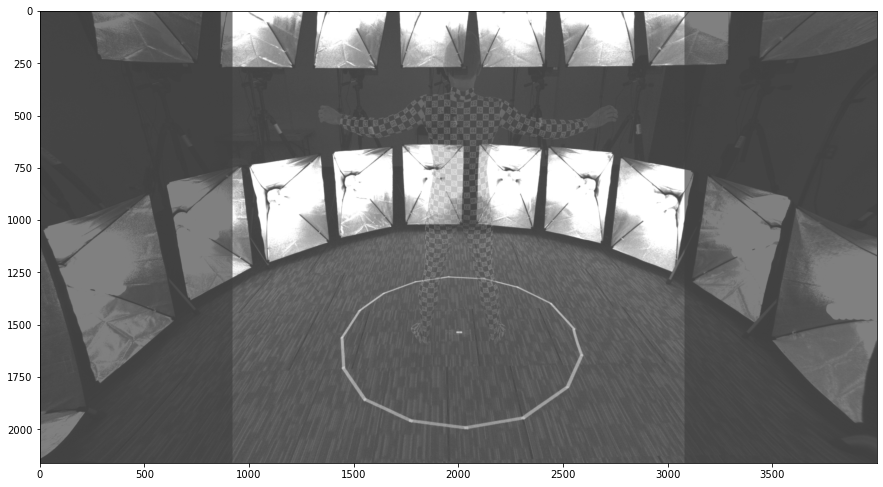

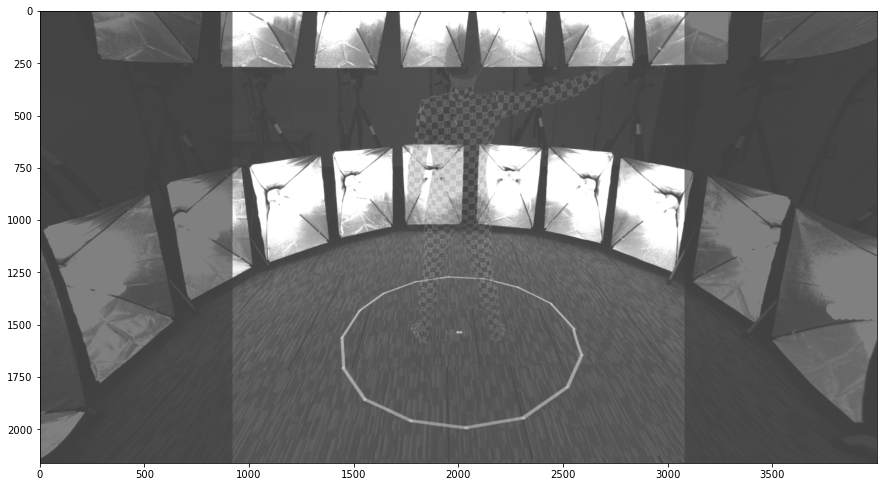

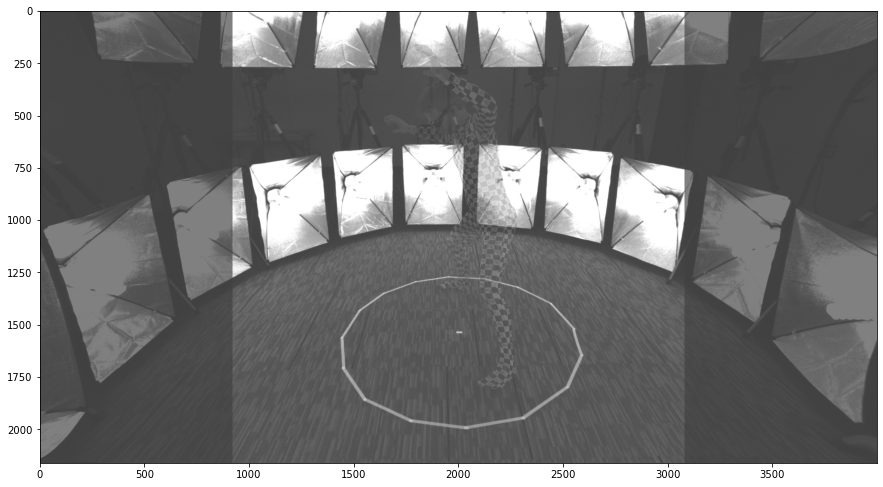

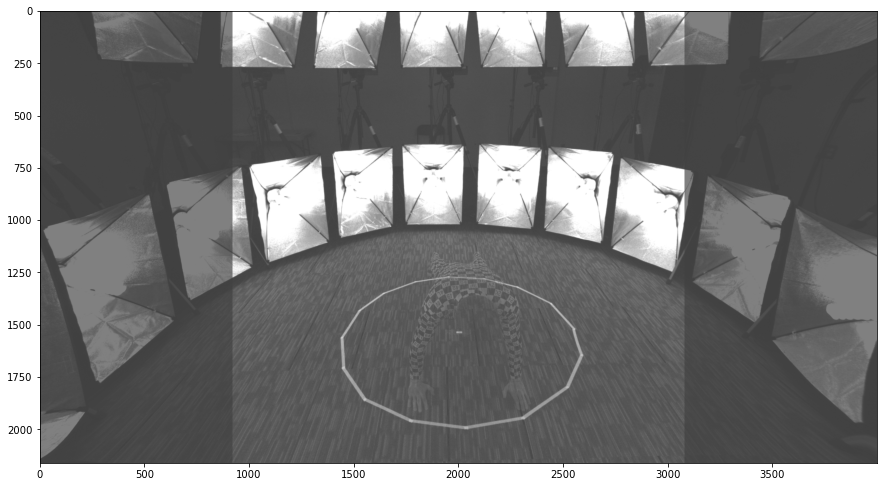

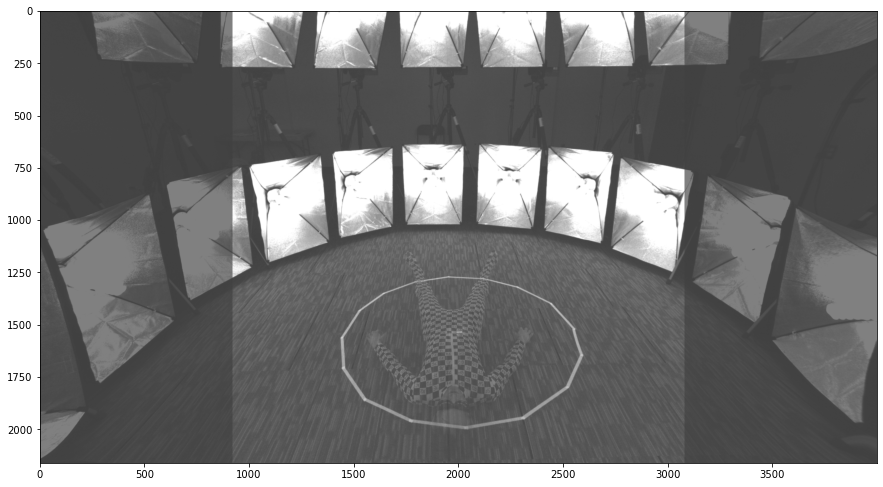

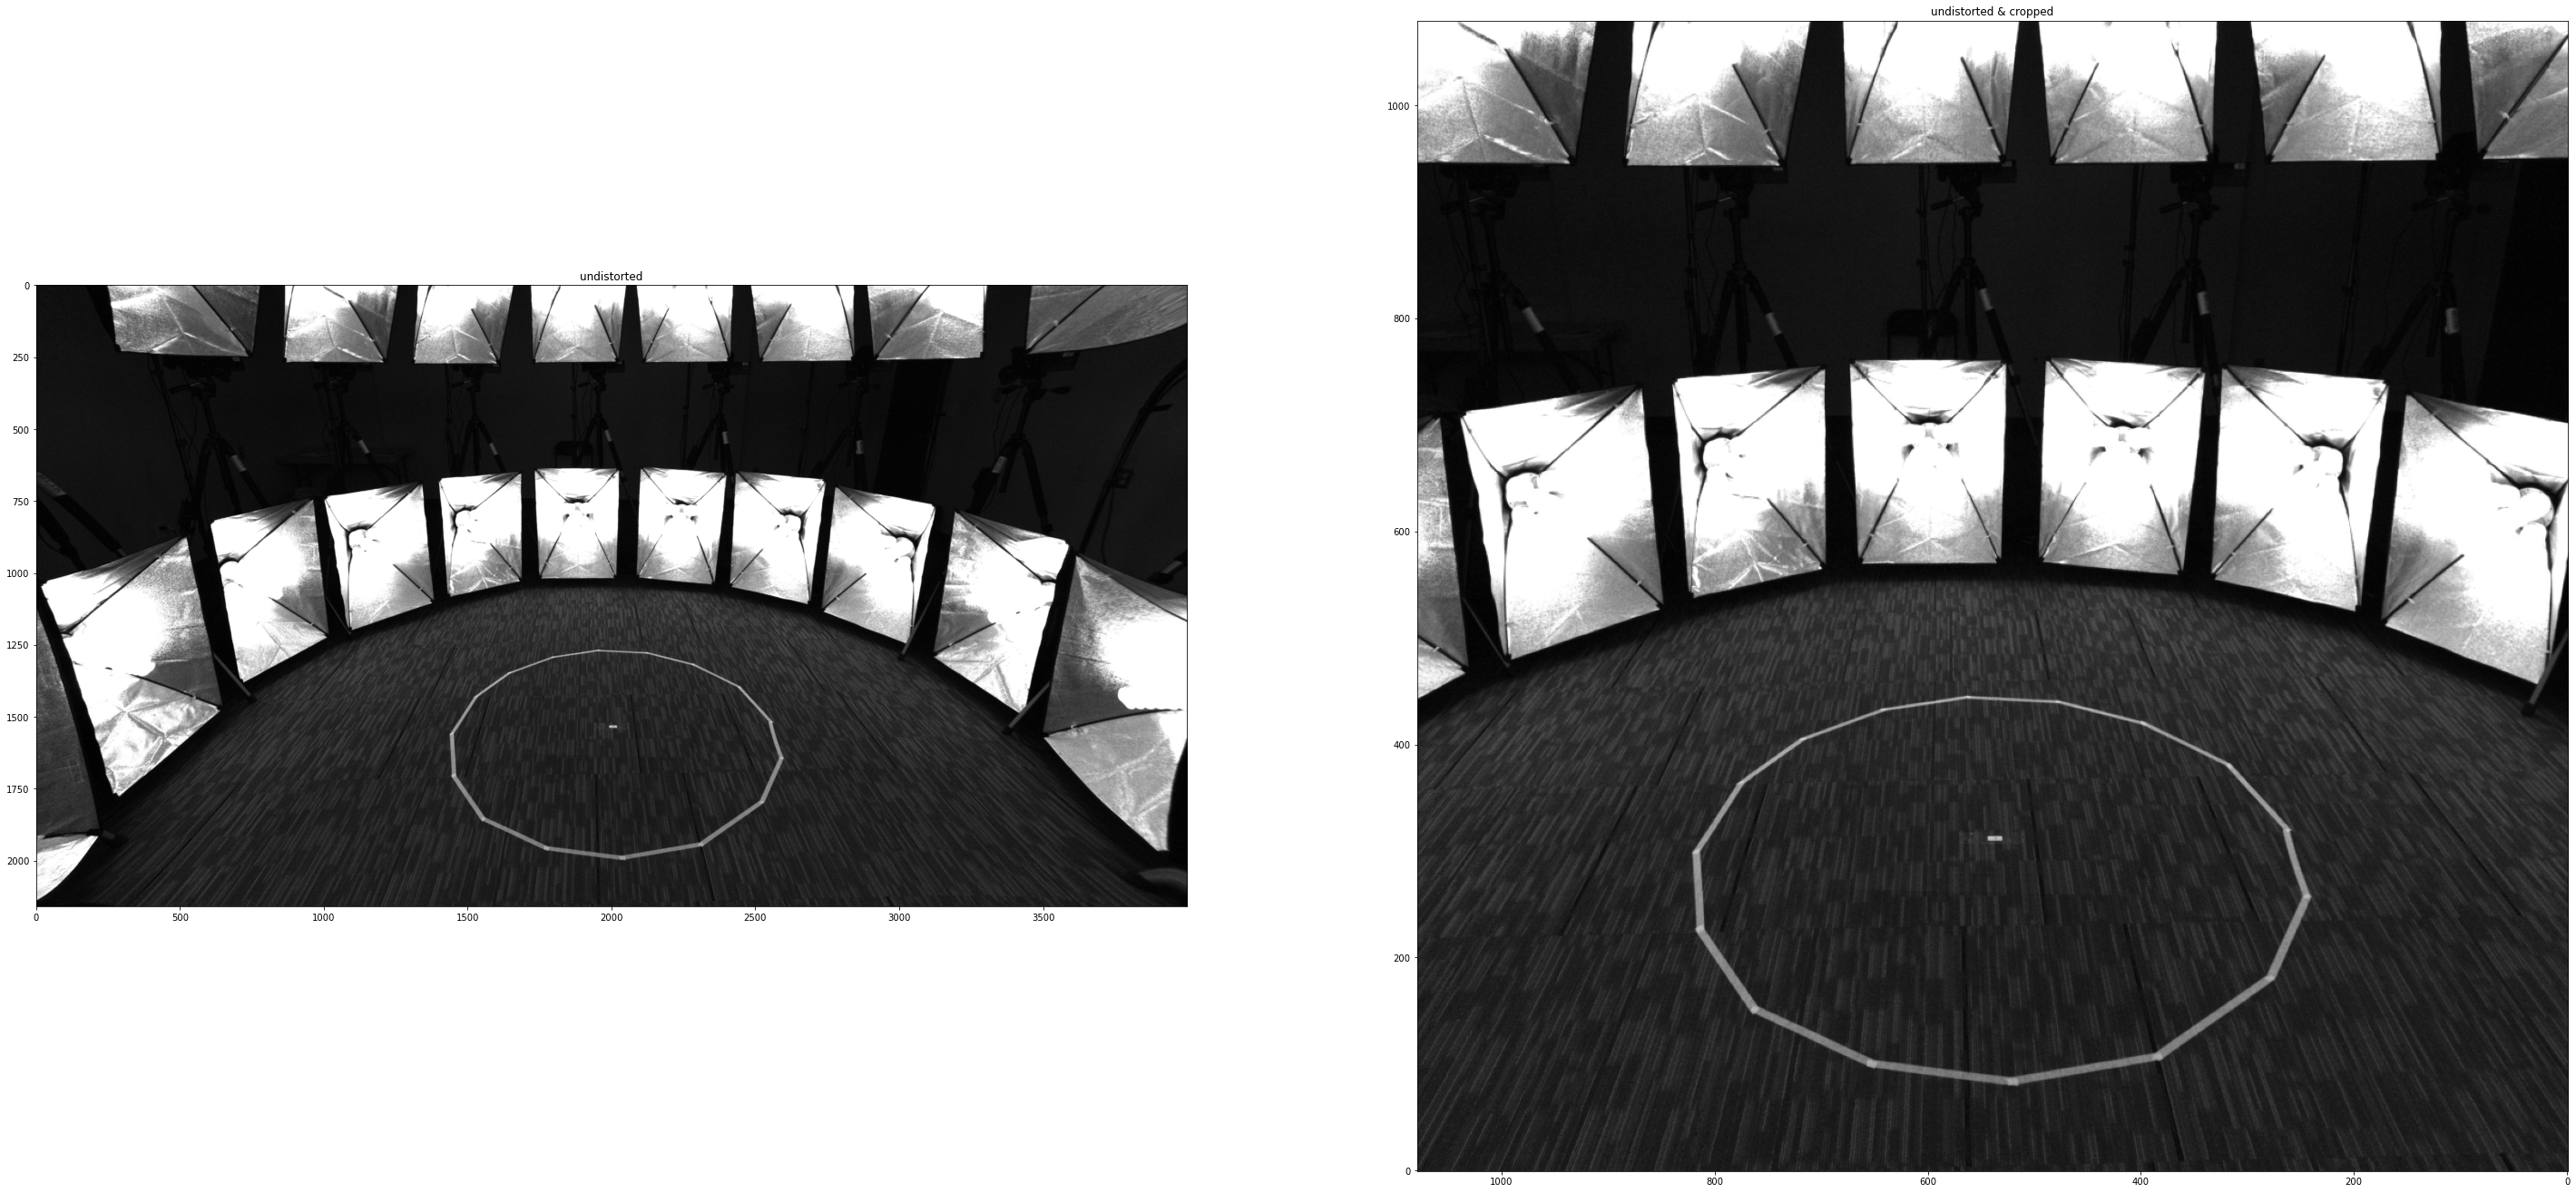

In [62]:
%matplotlib inline
img_name = '03052'
cam_idx = 0
img1 = img_refs_undistorted[img_name][cam_idx]
img2 = img_refs[img_name][cam_idx]
print('Image original =========')
print(' ', img1.shape, ',', np.max(img1), ',', img1.dtype)
print('   {:,.2f} Mb'.format(img1.nbytes * 0.000001))
print('Image cropped =========')
print(' ', img2.shape, ',', np.max(img2), ',', img2.dtype)
print('   {:,.2f} Mb'.format(img2.size * img2.itemsize * 0.000001))
print()

# overlay ref image & cropped ref image
for img_name in img_names:
    for i in range(16):
        # target image
        print(img_name, ':', len(img_refs_undistorted[img_name]))
        img1 = img_refs_undistorted[img_name][i]
        img2 = np.zeros((img1.shape[0], img1.shape[1]))
        cx = img2.shape[0] // 2
        cy = img2.shape[1] // 2
        imgref = cv2.flip(cv2.resize(img_refs[img_name][i], (img1.shape[0], img1.shape[0])), -1)
        w = imgref.shape[0] // 2
        h = imgref.shape[0] // 2 
        img2[cx-w:cx+w,cy-h:cy+h] = imgref
        
        cp = cv2.flip(cv2.resize(clean_plates[i], (img1.shape[0], img1.shape[0])), -1)
        img2[cx-w:cx+w,cy-h:cy+h] = cp
        
        plt.figure(figsize=(15, 15))
        plt.imshow(img1, cmap='gray', alpha=0.5)
        plt.imshow(img2, cmap='gray', alpha=0.5)
        break

for i in range(16):
    # clean plates
    img1 = clean_plates_undistort[i]
    img2 = clean_plates[i]
    fig, ax = plt.subplots(1, 2, figsize=(50, 50))
    ax[0].imshow(img1, cmap='gray')
    ax[0].set_title('undistorted')
    ax[1].imshow(img2, cmap='gray')
    ax[1].set_title('undistorted & cropped')
    ax[1].invert_yaxis()
    ax[1].invert_xaxis()
    plt.show()
    break

# Plots

In [63]:
def plot_6(out_dir, e, batch_idx, lr, img_name, cam_idx, loss_dict, grads, image_curr, image_target, texturemap, diff_masked):
    fig, ax = plt.subplots(1, 6, figsize=(30, 6), tight_layout=True)
    plt.suptitle('Epoch {} | {}.pgm | lr={}'.format(e, img_name, lr), fontsize=16)
    a_loss = ax[0]
#     a_grad = ax[1]
    a_curr = ax[1]
    a_target = ax[2]
    a_diff = ax[3]
    a_diff_masked = ax[4] 
    a_tex = ax[5]
    
    losses = loss_dict['total']
    legends = []
    a_loss.plot(losses, linewidth=3)
    for k, v in loss_dict.items():
        legends.append(k)
        if k != 'total':
            a_loss.plot(v)
    a_loss.set_title('losses: {}'.format(losses[-1]))
    a_loss.legend(legends)
    a_loss.grid()
    
#     a_grad.set_title('||grad||')
#     a_grad.grid()
    
    a_curr.imshow(image_curr, cmap='gray', vmin=0, vmax=1.0)
    a_curr.set_title('current | camera {}'.format(cam_idx))
    a_curr.set_xlabel('{}'.format(image_curr.shape))
    
    a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    a_target.set_title('target')
    a_target.set_xlabel('{}'.format(image_target.shape))
    
    diff = image_curr - image_target
    diff_abs = np.abs(diff)
    a_diff.imshow(diff_abs)
    a_diff.set_title('difference')
    a_diff.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(diff.shape, np.min(diff), np.max(diff)))
    
    a_diff_masked.imshow(diff_masked)
    a_diff_masked.set_title('masked difference')
    a_diff_masked.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(diff_masked.shape, np.min(diff_masked), np.max(diff_masked)))
    
    a_tex.imshow(np.clip(texturemap, a_min=0, a_max=1.0), cmap='gray', vmin=0, vmax=1.0)
    a_tex.set_title('texturemap')
    a_tex.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(texturemap.shape, np.min(texturemap), np.max(texturemap)))
    
    if out_dir is not None:
        out_path = out_dir + '/plot_{}.png'.format(e)
        plt.savefig(out_path, dpi=300)
        plt.close()
    
        plot_img = imageio.imread(out_path)
        return plot_img
    else:
        return None

def plot_3(out_dir, i, N, img_name, cam_idx, image_curr, image_target):
    fig, ax = plt.subplots(1, 3, figsize=(18, 7), tight_layout=True)
    plt.suptitle('[{}/{}] {}.pgm'.format(i+1, N, e, img_name), fontsize=16)
    a_curr = ax[0]
    a_target = ax[1]
    a_diff = ax[2]
    
    a_curr.imshow(image_curr, cmap='gray', vmin=0, vmax=1.0)
    a_curr.set_title('current | camera {}'.format(cam_idx))
    a_curr.set_xlabel('{}'.format(image_curr.shape))
    
    a_target.imshow(image_target, cmap='gray', vmin=0, vmax=1.0)
    a_target.set_title('target')
    a_target.set_xlabel('{}'.format(image_target.shape))
    
    diff = image_curr - image_target
    diff_abs = np.abs(diff)
    a_diff.imshow(diff_abs)
    a_diff.set_title('difference')
    a_diff.set_xlabel('{}, min={:.2f}, max={:.2f}'.format(diff.shape, np.min(diff), np.max(diff)))
    
    out_path = out_dir + '/plot_final_{}.png'.format(i)
    plt.savefig(out_path, dpi=300)
    plt.close()
    
    plot_img = imageio.imread(out_path)
    return plot_img

# === Train ===

In [64]:
def get_settings_str(img_names):
    log_str = ''
    
    log_str += '{:<15}: {}\n'.format('cameras', cam_path)
    log_str += '{:<15}: {}\n'.format('mesh', mesh_dir)
    log_str += '{:<15}: {}\n'.format('clean plates', clean_plate_dir)
    log_str += '{:<15}:'.format('images')
    for img_name in img_names:
        log_str += ' {}.pgm'.format(img_name)
    log_str += '\n'
    log_str += '---------------------------------------------\n\n'
    return log_str

In [65]:
img_names

['03052', '03067', '04735', '06550', '06250']

# RUN

In [66]:
import gc
# =================================================================================== #
batch_size = 2
n_batch = n_forwards // batch_size
model = Model(device, contours=contours, texturemap_path=None, texturemap_shape=texturemap_shape, img_dir=img_dir, cam_params=cams_torch, image_refs=img_refs, mesh_paths=mesh_paths, image_size=image_size, clean_plates=clean_plates, batch_size=batch_size, n_batch=n_batch)

print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))
# =================================================================================== #

out_dir = './26_data/output'

now = datetime.now()
date_str = '{}{:>02}{:>02}'.format(now.year, now.month, now.day)
log_path = out_dir + '/log_{}.txt'.format(date_str)
__output_log(log_path, '=== {} Start ==========================\n'.format(date_str))
__output_log(log_path, get_settings_str(img_names))

print('Log output: {}'.format(log_path))
loop = tqdm_notebook(range(1000000000))
loop.set_description('start')

lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=2, verbose=True)

losses = {}
images_last = None
targets_last = None
e_terminate = 100
for e in loop:
    t0 = time.time()
    
    images = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))
    targets = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))
    diffs_masked = np.empty((model.n_batch*model.batch_size, model.image_size, model.image_size))
    optimizer.zero_grad()

    save_plot = (e % 5 == 0)
    losses_minibatch = {}
    loss_curr = 0.0
    for batch_idx in range(model.n_batch):
        i0 = batch_idx*model.batch_size
        i1 = i0 + model.batch_size
        
        # ================== #
        # train
        # ================== #
        imgs, l, l_dict = model(batch_idx, learn_texturemap=True)
        l.backward()
        loss_curr += l

        images[i0:i1] = imgs['currents_with_bg'].squeeze().detach().cpu().numpy()
        targets[i0:i1] = imgs['targets'].squeeze().detach().cpu().numpy()
        diffs_masked[i0:i1] = imgs['diff_masked'].squeeze().detach().cpu().numpy()
        
        for k, v in l_dict.items():
            if k not in losses_minibatch:
                losses_minibatch[k] = 0.0
            losses_minibatch[k] += (v.detach().cpu().numpy() / model.n_batch)
            
        lr_curr = optimizer.param_groups[0]['lr']
        loop.set_description('[{}] batch[{}/{}] lr={:.4f}, loss={:.6f}\n'.format(e, batch_idx+1, model.n_batch, lr_curr, losses_minibatch['total']))

    optimizer.step()
    scheduler.step(loss_curr)
    
    for k, v in losses_minibatch.items():
        if k not in losses:
            losses[k] = []
        losses[k].append(v)
        
    t1 = time.time()
    
    # log
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    now = datetime.now()
    hour = str(now.hour)
    minute = str(now.minute)
    second = str(now.second)
    now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
    out_str = '{} | {:04} | {:.2f}s | lr={:.8f} | loss={:.6f} | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e, t1-t0, lr_curr, loss_curr, mb_alloc, mb_cached)
    __output_log(log_path, out_str)

    images_last = images.copy()
    targets_last = targets.copy()
    
    if save_plot:
        out_idx = 0
        texturemap = model.texture_map.clone().squeeze().detach().cpu().numpy()
        img_name = model.batch_dict['img_name'][out_idx]
        cam_idx = model.batch_dict['cam_idx'][out_idx]
        img_curr = cv2.flip(images[out_idx], -1)
        img_target = cv2.flip(targets[out_idx], -1)
        diff_masked = cv2.flip(diffs_masked[out_idx], -1)
        grads = None
        
        save_dir = out_dir
        plot_img = plot_6(save_dir, e, batch_idx, lr_curr, img_name, cam_idx, losses, grads, img_curr, img_target, texturemap, diff_masked)
        
        texturemap_out = (255.0*np.clip(model.texture_map.detach().squeeze().cpu().numpy(), a_min=0, a_max=1.0)).astype(np.uint8)
        im = Image.fromarray(texturemap_out)
        im.save(out_dir + '/texturemap_learned.png', dpi=(600, 600))
        
        if plot_img is not None:
            plt.figure(figsize=(30, 6))
            plt.imshow(plot_img)
            plt.xticks([]), plt.yticks([])
            plt.show()
            
    if lr_curr < 1e-10 or e == e_terminate:
        # save texturemap
        texels_np = model.texture_map.clone().detach().cpu().numpy()
        np.save(out_dir + '/texturemap.npy', texels_np)
        del texels_np
        print('lr={}. BREAK'.format(lr_curr))
        
        
        plt.figure(figsize=(30, 6))
        plt.imshow(plot_img)
        plt.xticks([]), plt.yticks([])
        plt.show()
        break  
           

L2 Loss
----- torch.cuda.empty_cache() -----
torch.cuda.memory_allocated(): 941.76 Mb
torch.cuda.memory_cached(): 1,402.99 Mb
Log output: ./26_data/output/log_20200623.txt


<ipython-input-66-f973e8f85f79>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(1000000000))


KeyboardInterrupt: 

# save, if not saved

In [14]:
# save texturemap
texels_np = model.texture_map.clone().detach().cpu().numpy()
np.save(out_dir + '/texturemap.npy', texels_np)